# Indeed Take-Home Assessment

**Objective:** The goal of this assessment is to predict the salaries of employees.

## Importing Libraries/Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.feature_selection import RFE, SelectKBest, chi2
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

## Loading the Data

In [2]:
train_features = pd.read_csv('train_features.csv')
train_salaries = pd.read_csv('train_salaries.csv')

In [3]:
test_features = pd.read_csv('test_features.csv')

## Data Cleaning and Analysis

#### Inspecting the first five rows of the feature dataset

In [4]:
train_features.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


#### Inspecting the first five rows of the salaries dataset

In [5]:
train_salaries.head()

,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


#### Inspecting the shape of both the datasets

In [6]:
print(f"The shape of the features dataset is: {train_features.shape}")
print(f"The shape of the salaries dataset is: {train_salaries.shape}")

The shape of the features dataset is: (1000000, 8)
The shape of the salaries dataset is: (1000000, 2)


#### Looking at the number of unique job Id's in the feature and salaries dataset

In [7]:
print(f"Number of unique jobId's in the features dataset: {train_features.jobId.nunique()}")
print(f"Number of unique jobId's in the salaries dataset: {train_salaries.jobId.nunique()}")

Number of unique jobId's in the features dataset: 1000000
Number of unique jobId's in the salaries dataset: 1000000


#### Now that we see that there are equal number of jobId's in the features and salaries dataset, we do an inner join on the jobId's to merge both the datasets to get the resulting dataframe

In [8]:
train_df = pd.merge(train_features, train_salaries, how='inner', left_on='jobId', right_on='jobId')

In [9]:
train_df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [10]:
train_df.tail()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
999995,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88
999996,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160
999997,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999998,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149
999999,JOB1362685407686,COMP59,JUNIOR,BACHELORS,NONE,EDUCATION,20,11,88


#### Dropping any possible duplicates present in our dataset

In [11]:
train_df.drop_duplicates(inplace=True)

#### Looking at the number of NULL's present in our dataset

In [12]:
train_df.isnull().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

**Reflection:** We don't find any NULL's in the training dataset and can do a further analysis.

#### Exploring the information of each feature in the dataframe

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


#### Exploring the descriptive statistics of each feature in the dataframe

In [14]:
train_df.describe(include='all')

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
count,1000000,1000000,1000000,1000000,1000000,1000000,1000000.000000,1000000.000000,1000000.000000
unique,1000000,63,8,5,9,7,NaN,NaN,NaN
top,JOB1362685057196,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB,NaN,NaN,NaN
freq,1,16193,125886,236976,532355,143206,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,11.992386,49.529260,116.061818
std,NaN,NaN,NaN,NaN,NaN,NaN,7.212391,28.877733,38.717936
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,6.000000,25.000000,88.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,12.000000,50.000000,114.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,18.000000,75.000000,141.000000


**Reflection:** After looking at the dtypes and the description of each column, we observe that there are plenty of unique values in *jobId*, *companyId*, *jobType*, *degree*, *major*, and *industry*. We also observe that the minimum values in the yearsExperience, milesFromMetropolis and salary is 0. Though, *yearsExperience* and *milesFromMetropolis* can be 0, a 0 *salary* is slightly unususal and worth having a look at!

#### We convert the following columns from object to categorical: companyId, jobType, degree, major and industry. These because they have tonnes of repitions and converting these to categorical can speed up the processing. 

In [15]:
train_df['companyId'] = train_df['companyId'].astype('category')
train_df['jobType'] = train_df['jobType'].astype('category')
train_df['degree'] = train_df['degree'].astype('category')
train_df['major'] = train_df['major'].astype('category')
train_df['industry'] = train_df['industry'].astype('category')

In [16]:
test_features['companyId'] = test_features['companyId'].astype('category')
test_features['jobType'] = test_features['jobType'].astype('category')
test_features['degree'] = test_features['degree'].astype('category')
test_features['major'] = test_features['major'].astype('category')
test_features['industry'] = test_features['industry'].astype('category')

In [17]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype   
---  ------               --------------    -----   
 0   jobId                1000000 non-null  object  
 1   companyId            1000000 non-null  category
 2   jobType              1000000 non-null  category
 3   degree               1000000 non-null  category
 4   major                1000000 non-null  category
 5   industry             1000000 non-null  category
 6   yearsExperience      1000000 non-null  int64   
 7   milesFromMetropolis  1000000 non-null  int64   
 8   salary               1000000 non-null  int64   
dtypes: category(5), int64(3), object(1)
memory usage: 42.9+ MB


#### Looking at the suspicious observations that have a 0 salary

In [18]:
train_df[train_df.salary == 0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


**Reflection:** Since there are very few observations with a salary of 0, we can drop these observations from the original dataset

In [19]:
train_df = train_df.drop(train_df[train_df.salary == 0].index).reset_index().drop('index', axis=1)

In [20]:
train_df.shape

(999995, 9)

#### Looking at the unique values in each categorical column

In [21]:
train_df.companyId.unique()

['COMP37', 'COMP19', 'COMP52', 'COMP38', 'COMP7', ..., 'COMP32', 'COMP62', 'COMP35', 'COMP18', 'COMP60']
Length: 63
Categories (63, object): ['COMP37', 'COMP19', 'COMP52', 'COMP38', ..., 'COMP62', 'COMP35', 'COMP18', 'COMP60']

**Reflection**: We find 63 uniques and there are no empty/None values in the feature.

In [22]:
train_df.jobType.unique()

['CFO', 'CEO', 'VICE_PRESIDENT', 'MANAGER', 'JUNIOR', 'JANITOR', 'CTO', 'SENIOR']
Categories (8, object): ['CFO', 'CEO', 'VICE_PRESIDENT', 'MANAGER', 'JUNIOR', 'JANITOR', 'CTO', 'SENIOR']

**Reflection**: We find 8 uniques and no empty/None values!

In [23]:
train_df.degree.unique()

['MASTERS', 'HIGH_SCHOOL', 'DOCTORAL', 'BACHELORS', 'NONE']
Categories (5, object): ['MASTERS', 'HIGH_SCHOOL', 'DOCTORAL', 'BACHELORS', 'NONE']

In [24]:
train_df.major.unique()

['MATH', 'NONE', 'PHYSICS', 'CHEMISTRY', 'COMPSCI', 'BIOLOGY', 'LITERATURE', 'BUSINESS', 'ENGINEERING']
Categories (9, object): ['MATH', 'NONE', 'PHYSICS', 'CHEMISTRY', ..., 'BIOLOGY', 'LITERATURE', 'BUSINESS', 'ENGINEERING']

**Reflection:** We find 5 unique values in degree and 9 unique values in major. There are 'NONE' values in both these columns. We need to analyze the cause for it!

#### There are a couple of possibilities - both are NONE, either are NONE and neither are NONE. Let's look at each of them!

In [25]:
train_df[(train_df.degree == 'NONE') & (train_df.major == 'NONE')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24,178
12,JOB1362684407699,COMP4,JUNIOR,NONE,NONE,OIL,8,29,79
14,JOB1362684407701,COMP57,JANITOR,NONE,NONE,AUTO,21,81,47
20,JOB1362684407707,COMP44,JANITOR,NONE,NONE,SERVICE,11,96,32
21,JOB1362684407708,COMP20,JUNIOR,NONE,NONE,AUTO,14,62,68
...,...,...,...,...,...,...,...,...,...
999972,JOB1362685407664,COMP28,CFO,NONE,NONE,HEALTH,12,46,142
999973,JOB1362685407665,COMP53,VICE_PRESIDENT,NONE,NONE,SERVICE,18,94,93
999979,JOB1362685407671,COMP1,CTO,NONE,NONE,SERVICE,6,20,110
999980,JOB1362685407672,COMP62,CEO,NONE,NONE,AUTO,5,13,147


#### Exploring the places where the degree is NONE and the major is not NONE

In [26]:
train_df[(train_df.degree == 'NONE') & (train_df.major != 'NONE')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary


#### Exploring observations where the degree is NOT NONE and the major is NONE

In [27]:
train_df[(train_df.degree != 'NONE') & (train_df.major == 'NONE')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54,31
10,JOB1362684407697,COMP56,JANITOR,HIGH_SCHOOL,NONE,HEALTH,24,30,102
24,JOB1362684407711,COMP20,CEO,BACHELORS,NONE,WEB,12,8,202
28,JOB1362684407715,COMP11,JANITOR,HIGH_SCHOOL,NONE,FINANCE,20,23,101
...,...,...,...,...,...,...,...,...,...
999985,JOB1362685407677,COMP39,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,17,23,89
999991,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160
999992,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999993,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149


#### Exploring observations where the degree is NOT NONE and the major is NOT NONE

In [28]:
train_df[(train_df.degree != 'NONE') & (train_df.major != 'NONE')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31,113
...,...,...,...,...,...,...,...,...,...
999983,JOB1362685407675,COMP6,JUNIOR,DOCTORAL,BUSINESS,HEALTH,4,70,79
999987,JOB1362685407679,COMP30,MANAGER,DOCTORAL,PHYSICS,WEB,16,16,143
999988,JOB1362685407680,COMP21,CFO,MASTERS,CHEMISTRY,SERVICE,4,6,136
999989,JOB1362685407681,COMP40,CFO,BACHELORS,COMPSCI,EDUCATION,18,77,115


#### Exploring the number of NONE's in the degree

In [29]:
degree_frequency_df = pd.DataFrame(train_df.degree.value_counts(normalize=True) * 100).reset_index().rename(columns={'index': 'degree', 'degree': 'frequency'})
degree_frequency_df

,degree,frequency
0,HIGH_SCHOOL,23.697618
1,NONE,23.685418
2,BACHELORS,17.549588
3,DOCTORAL,17.536288
4,MASTERS,17.531088


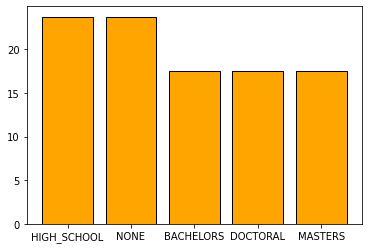

In [30]:
plt.bar(degree_frequency_df['degree'], degree_frequency_df['frequency'], edgecolor = 'black', color = 'orange');

**Reflection:** There are 23.68% 'NONE' values in the dataset

#### Exploring the number of NONE's in the major

In [31]:
major_frequency_df = pd.DataFrame(train_df.major.value_counts(normalize=True) * 100).reset_index().rename(columns={'index': 'major', 'major': 'frequency'})
major_frequency_df

,major,frequency
0,NONE,53.235566
1,CHEMISTRY,5.887529
2,LITERATURE,5.868429
3,ENGINEERING,5.859429
4,BUSINESS,5.851829
5,PHYSICS,5.841029
6,COMPSCI,5.838229
7,BIOLOGY,5.837929
8,MATH,5.780029


<AxesSubplot:ylabel='major'>

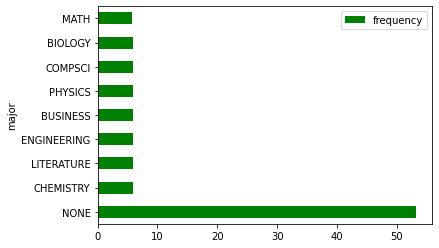

In [32]:
major_frequency_df.plot.barh(x='major', y='frequency', color='green')

**Reflection**: There are 53% NONEs that means over half the training dataset doesn't have any values in the major section!

In [33]:
train_df.industry.unique()

['HEALTH', 'WEB', 'AUTO', 'FINANCE', 'EDUCATION', 'OIL', 'SERVICE']
Categories (7, object): ['HEALTH', 'WEB', 'AUTO', 'FINANCE', 'EDUCATION', 'OIL', 'SERVICE']

#### Looking at all the categorical variables against the salaries

<Figure size 1440x1440 with 0 Axes>

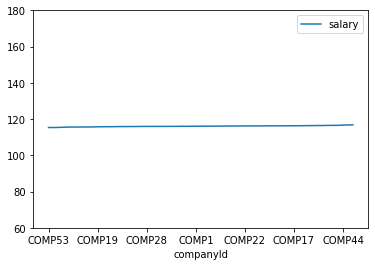

In [34]:
fig = plt.figure(figsize=(20, 20))
companyId_salary = pd.DataFrame(train_df.groupby(['companyId'])['salary'].mean().sort_values());
companyId_salary.plot.line();
plt.ylim(60, 180);

**Reflection:** The salaries don't vary much with respect to the companies and can possibly be ruled out.

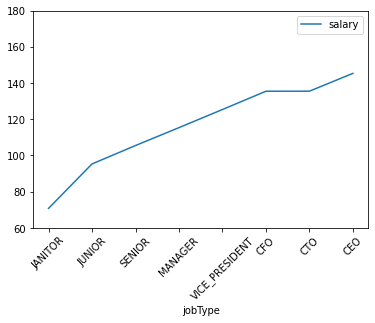

In [35]:
jobType_salary = pd.DataFrame(train_df.groupby(['jobType'])['salary'].mean().sort_values());
jobType_salary.plot.line();
plt.xticks(range(0,len(jobType_salary.index)), jobType_salary.index, rotation=45);
plt.ylim(60, 180);

**Reflection:** This clearly indicates that the CEO has the highest average salary and the janitor has the lowest average salary. 

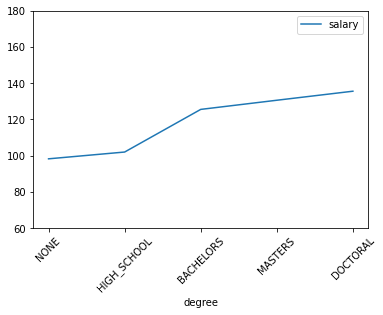

In [36]:
degree_salary = pd.DataFrame(train_df.groupby(['degree'])['salary'].mean().sort_values());
degree_salary.plot.line();
plt.xticks(range(0,len(degree_salary.index)), degree_salary.index, rotation=45);
plt.ylim(60, 180);

**Reflection:** Having a Doctorate degree will give you the highest salary.

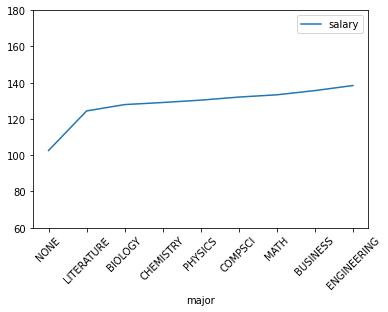

In [37]:
major_salary = pd.DataFrame(train_df.groupby(['major'])['salary'].mean().sort_values());
major_salary.plot.line();
plt.xticks(range(0,len(major_salary.index)), major_salary.index, rotation=45);
plt.ylim(60, 180);

**Reflection:** Engineers and Business Majors earn the maximum and Literature majors earn the least

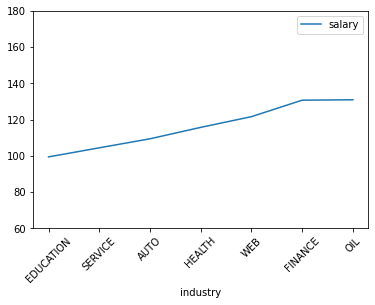

In [38]:
industry_salary = pd.DataFrame(train_df.groupby(['industry'])['salary'].mean().sort_values());
industry_salary.plot.line();
plt.xticks(range(0,len(industry_salary.index)), industry_salary.index, rotation=45);
plt.ylim(60, 180);

**Reflection:** Oil and Finance sectors pay the most!

#### Looking at the boxplots of the numeric columns to see if there are any outliers present in the data

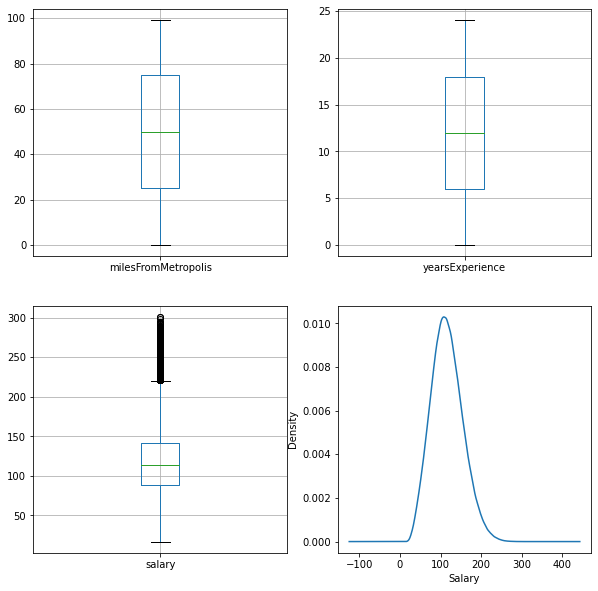

In [39]:
f = plt.figure(figsize=(10, 10))

ax = f.add_subplot(2, 2, 1)
train_df.boxplot(column=['milesFromMetropolis'])

ax = f.add_subplot(2, 2, 2)
train_df.boxplot(column=['yearsExperience'])

ax = f.add_subplot(2, 2, 3)
train_df.boxplot(column=['salary'])

ax = f.add_subplot(2, 2, 4)
train_df.salary.plot.kde();
plt.xlabel('Salary');

**Reflection:** Years of Experience and Miles From Metropolis don't have any outliers! The salary column though has outliers! There seem to be plenty of values that are outside the maximum value of the boxplot! I have also plotted a normal distribution curve to see validate that there are plenty of outliers! We need to dig deeper to understand the causes!

#### Looking at the different quartiles and finding the five values of the boxplot. These can then be used further to analyze the outliers.

In [40]:
first_quartile = np.percentile(train_df.salary, 25)
third_quartile = np.percentile(train_df.salary, 75)
median = train_df.salary.median()
maximum = third_quartile + 1.5 * (third_quartile - first_quartile)
minimum = first_quartile - 1.5 * (third_quartile - first_quartile)

#### Looking at all the records with salary lesser than the minimum value (outlier)

In [41]:
train_df[(train_df.salary < minimum)]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary


**Reflection:** We don't find any values here.

#### Looking at the records with salary greater than the maximum value (outlier)

In [42]:
train_df[(train_df.salary > maximum)]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
266,JOB1362684407953,COMP30,CEO,MASTERS,BIOLOGY,OIL,23,60,223
362,JOB1362684408049,COMP38,CTO,MASTERS,NONE,HEALTH,24,3,223
560,JOB1362684408247,COMP53,CEO,MASTERS,BIOLOGY,WEB,22,7,248
670,JOB1362684408357,COMP26,CEO,MASTERS,MATH,AUTO,23,9,240
719,JOB1362684408406,COMP54,VICE_PRESIDENT,DOCTORAL,BIOLOGY,OIL,21,14,225
...,...,...,...,...,...,...,...,...,...
998511,JOB1362685406203,COMP29,CFO,MASTERS,ENGINEERING,WEB,14,46,227
999244,JOB1362685406936,COMP30,CEO,NONE,NONE,OIL,17,10,223
999275,JOB1362685406967,COMP2,CFO,BACHELORS,BUSINESS,SERVICE,21,0,228
999665,JOB1362685407357,COMP20,CEO,DOCTORAL,LITERATURE,SERVICE,24,14,233


**Reflection:** We find plenty of observations here! Only a box-plot doesn't justify if these values are actually outliers. We can now look at the jobType to understand if these outliers can be considered or should be removed.

In [43]:
train_df[train_df.salary > maximum].jobType.value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
JANITOR              0
Name: jobType, dtype: int64

**Reflection:** Looking at the distribution of data, we observe that most of the salaries that exceeed the maximum are for CEO, CFO, CTO, VICE_PRESIDENT and MANAGER - these can be ignored and kept as is because these positions can have high salaries. 

#### We now look at SENIOR and JUNIOR individually.

In [44]:
train_df[(train_df.salary > maximum) & (train_df.jobType == 'SENIOR')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
23150,JOB1362684430837,COMP23,SENIOR,MASTERS,MATH,WEB,24,5,239
27880,JOB1362684435567,COMP60,SENIOR,MASTERS,ENGINEERING,WEB,20,10,225
60438,JOB1362684468126,COMP46,SENIOR,DOCTORAL,ENGINEERING,OIL,19,41,225
79241,JOB1362684486929,COMP5,SENIOR,DOCTORAL,BUSINESS,FINANCE,21,29,243
94728,JOB1362684502416,COMP3,SENIOR,MASTERS,ENGINEERING,WEB,22,0,227
...,...,...,...,...,...,...,...,...,...
923361,JOB1362685331053,COMP9,SENIOR,BACHELORS,ENGINEERING,OIL,23,0,225
980193,JOB1362685387885,COMP24,SENIOR,BACHELORS,ENGINEERING,FINANCE,21,6,225
984689,JOB1362685392381,COMP45,SENIOR,BACHELORS,ENGINEERING,OIL,23,4,235
997011,JOB1362685404703,COMP4,SENIOR,DOCTORAL,ENGINEERING,OIL,24,12,233


**Reflection:** We see 66 entries and this doesn't give us a clear picture if these are actually outliers.

#### We now look at the distribution of each degree in the SENIOR jobType.

In [45]:
train_df[(train_df.salary > maximum) & (train_df.jobType == 'SENIOR')].degree.value_counts()

DOCTORAL       28
MASTERS        25
BACHELORS      13
NONE            0
HIGH_SCHOOL     0
Name: degree, dtype: int64

**Reflection:** Looking at the distribution of degrees these SENIORS have, we can say that having a DOCTORAL or a MASTERS degree can be a SENIOR and it's justified for them to have a higher salary. 13 BACHELORS look suspicious, we'll dig deeper!

In [46]:
train_df[(train_df.salary > maximum) & (train_df.jobType == 'SENIOR') & (train_df.degree == 'BACHELORS')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
126834,JOB1362684534522,COMP40,SENIOR,BACHELORS,ENGINEERING,OIL,23,1,242
235000,JOB1362684642688,COMP21,SENIOR,BACHELORS,COMPSCI,FINANCE,23,1,221
245537,JOB1362684653225,COMP50,SENIOR,BACHELORS,BUSINESS,FINANCE,24,4,237
316587,JOB1362684724275,COMP46,SENIOR,BACHELORS,ENGINEERING,OIL,23,36,225
338995,JOB1362684746683,COMP2,SENIOR,BACHELORS,BUSINESS,FINANCE,18,4,233
477697,JOB1362684885385,COMP32,SENIOR,BACHELORS,BUSINESS,OIL,24,2,240
518285,JOB1362684925974,COMP59,SENIOR,BACHELORS,BIOLOGY,OIL,24,3,228
580767,JOB1362684988456,COMP27,SENIOR,BACHELORS,BUSINESS,FINANCE,22,15,240
762638,JOB1362685170328,COMP26,SENIOR,BACHELORS,ENGINEERING,FINANCE,21,7,222
804843,JOB1362685212533,COMP48,SENIOR,BACHELORS,ENGINEERING,OIL,23,22,230


**Reflection:** Looking at this, we clearly see that the OIL and FINANCE are the two industries that have higher salaries. Everyone has over 20 years of experience as well and hence they cannot be considered to be outliers.

#### We now look at the JUNIORS who exceed the maximum cap

In [47]:
train_df[(train_df.salary > maximum) & (train_df.jobType == 'JUNIOR')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31354,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100041,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160332,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
189581,JOB1362684597269,COMP32,JUNIOR,DOCTORAL,BUSINESS,OIL,24,11,221
214605,JOB1362684622293,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4,222
303777,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348353,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
427592,JOB1362684835280,COMP54,JUNIOR,DOCTORAL,ENGINEERING,FINANCE,23,3,221


**Reflection:** The JUNIORS who have a high salary have either a MASTERS or a DOCTORATE degree and their experience is almost over 20 years and it's justified to keep them as is.

#### Converting the categorical variables to dummy variables (One-hot encoding)

In [48]:
train_df_temp = pd.get_dummies(train_df, columns=['companyId', 'jobType', 'degree', 'major', 'industry'], drop_first=True)
test_df_dummies = pd.get_dummies(test_features, columns=['companyId', 'jobType', 'degree', 'major', 'industry'], drop_first=True)

#### Considering only a subset of data due to lack of computational power

In [49]:
train_df_dummies = train_df_temp.sample(n=len(train_df_temp)//2, random_state=1245245).reset_index().drop(columns='index')

#### Exploring the correlation of every feature with the target variable to better understand feature importance

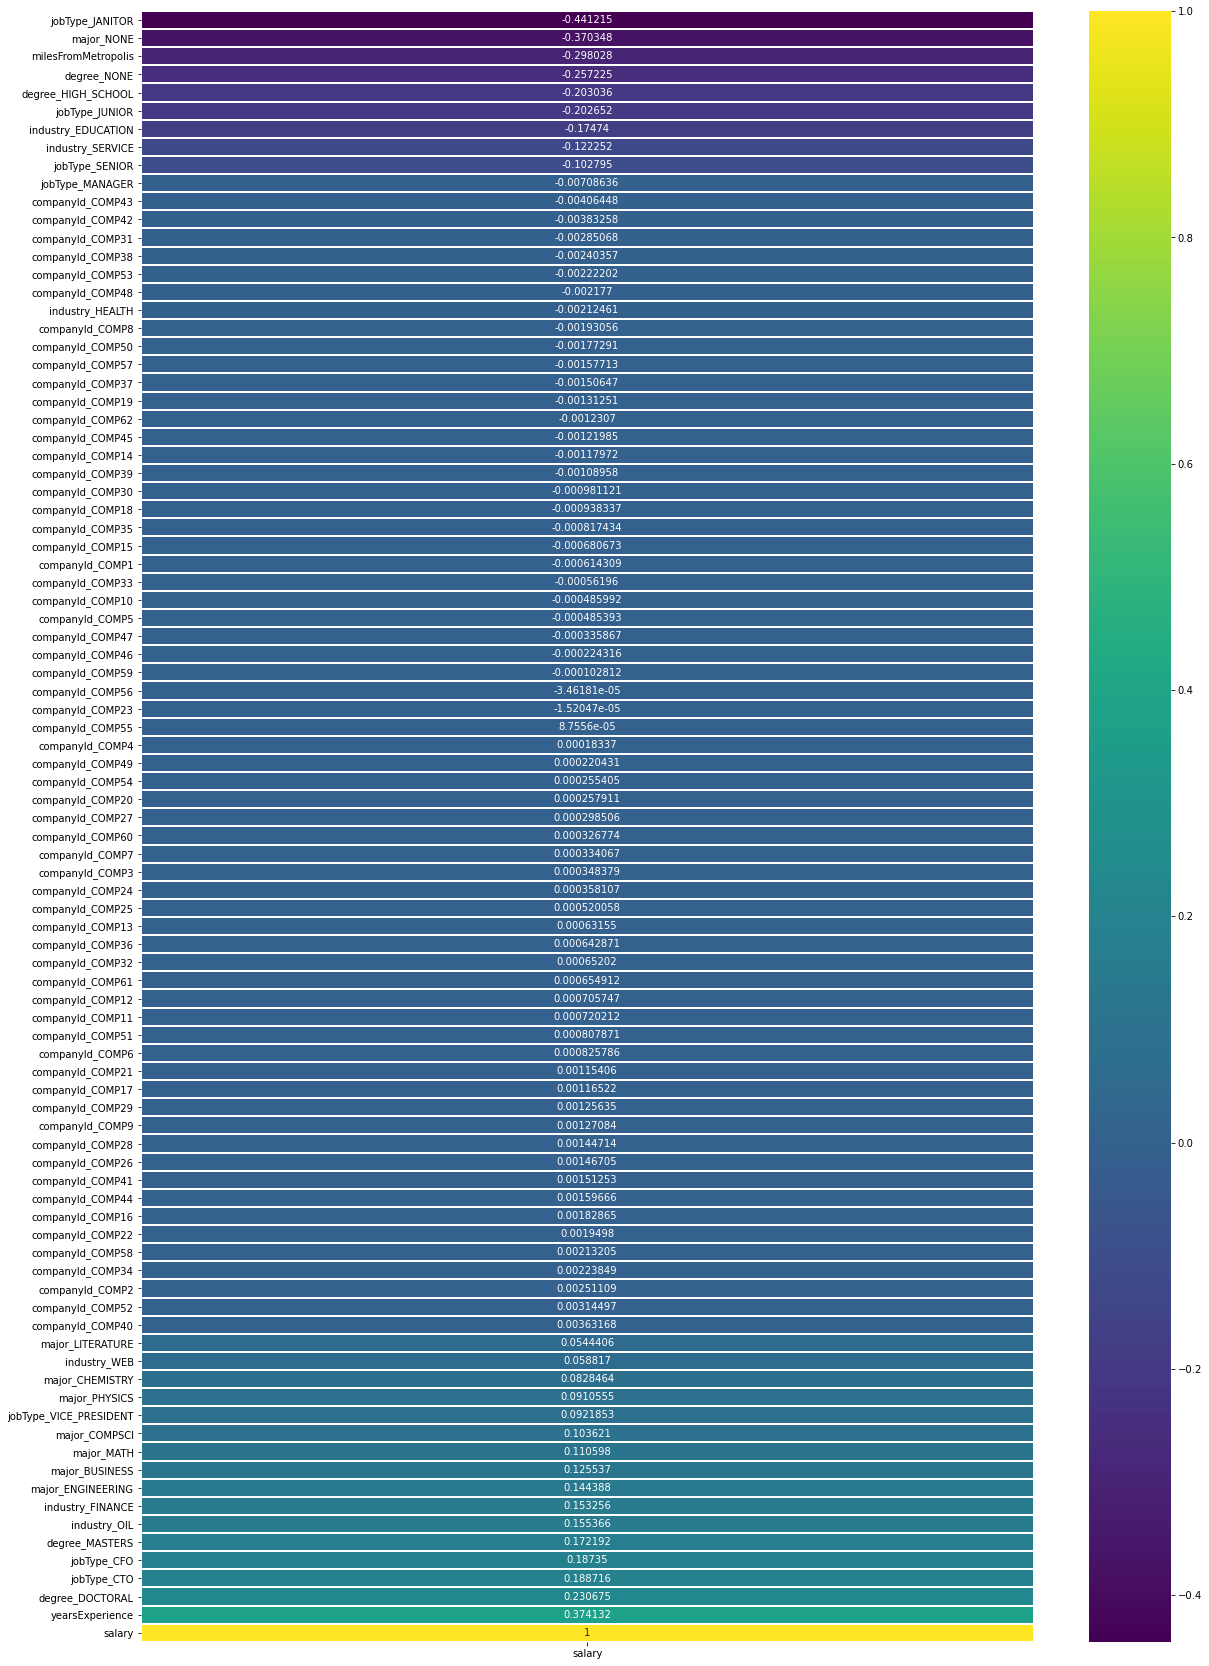

In [50]:
fig, ax = plt.subplots(figsize=(20, 30))  
sns.heatmap(pd.DataFrame(train_df_dummies.corr().loc[:, 'salary'].sort_values()), annot=True, fmt="g", cmap='viridis', linewidths=1, ax=ax)
fig.savefig('heatmap.png', bbox_inches='tight', dpi=150);

**Reflection:** Looking at the correlation of all the independent features with the dependent feature (salary), we observe that yearsExperience is positively correlated with the salary and milesFromMetropolis is negatively correlated. We also observe that the salary of the Janitor is negatively correlated and of the CEO/CFO is positively correlated which are expected! This is a good starting point to create a base model. We also observe that the companyId's don't show either a positive correlation or a negative correlation and as seen earlier too, that the salary doesn't change with the companyId's, we can remove the companyId's from the features! 

#### Removing the jobId and all the companyId's

In [51]:
to_remove = ['jobId']
for i in range(1, 63):
    to_remove.append(f"companyId_COMP{i}")
train_df_dummies.drop(columns=to_remove, inplace=True)

In [52]:
to_remove = ['jobId']
final_prediction = pd.DataFrame(test_df_dummies['jobId'])
for i in range(1, 63):
    to_remove.append(f"companyId_COMP{i}")
test_df_dummies.drop(columns=to_remove, inplace=True)

## Modeling

### Prediction using all the features

#### Creating x and y for inputting into the model.

In [53]:
x_df = train_df_dummies.loc[:, train_df_dummies.columns != 'salary']
y = train_df_dummies['salary']

In [54]:
x = x_df.to_numpy()

#### - Single-Degree Linear Regression  

Linear regression is easy to implement and interpret. This helps us understand the relationship between the independent and dependent variables. We have also ultilised cross validation here to get an idea of how accurately the model will perform when in practice. The main goal of using cross validation is to evaluate the model's performance on data which was not used to build it.


In [55]:
rmse = []
linear_reg = LinearRegression()
cv = KFold(n_splits=5, random_state=42, shuffle=False)

for train_index, validation_index in cv.split(x):
    x_train, x_validation, y_train, y_validation = x[train_index], x[validation_index], y[train_index], y[validation_index]
    linear_reg.fit(x_train, y_train)
    y_pred = linear_reg.predict(x_validation)
    rmse.append(mean_squared_error(y_validation, y_pred, squared=False))
print(f"The average RMSE for Linear Regression (one-degree) is: {sum(rmse)/5}")

The average RMSE for Linear Regression (one-degree) is: 19.612571979614323


#### - Second-degree Linear (Polynomial) Regression

Polynomial regression helps us capture the non-linear relationship between the independent and dependant variables. It is kind of similar to the other available non-parametric methods.

In [56]:
rmse = []
linear_reg = LinearRegression()
poly_reg = PolynomialFeatures(degree=2)
cv = KFold(n_splits=5, random_state=42, shuffle=False)

for train_index, validation_index in cv.split(x):
    x_train, x_validation, y_train, y_validation = x[train_index], x[validation_index], y[train_index], y[validation_index]
    x_poly = poly_reg.fit_transform(x_train)
    poly_reg.fit(x_poly, y_train)
    linear_reg.fit(x_poly, y_train)
    y_pred = linear_reg.predict(poly_reg.fit_transform(x_validation))
    rmse.append(mean_squared_error(y_validation, y_pred, squared=False))
print(f"The average RMSE for Linear Regression (second-degree) is: {sum(rmse)/5}")

The average RMSE for Linear Regression (second-degree) is: 18.82269217303709


#### - Lasso Regression 

Linear regression methods sometimes lead to overfitting, in this case, we can utilise lasso or ridge regression to avoid it and simplify it using feature selection. Lasso and Ridge shrinks the variable towards zero depending on their significance, the main difference being lasso can completely eliminate a variable where as Ridge can only shrink it. We have performed both of these below:

In [57]:
rmse = []
lasso_reg = Lasso(alpha=0.1)
cv = KFold(n_splits=5, random_state=42, shuffle=False)

for train_index, validation_index in cv.split(x):
    x_train, x_validation, y_train, y_validation = x[train_index], x[validation_index], y[train_index], y[validation_index]
    lasso_reg.fit(x_train, y_train)
    y_pred = lasso_reg.predict(x_validation)
    rmse.append(mean_squared_error(y_validation, y_pred, squared=False))
print(f"The average RMSE for Lasso Regression is: {sum(rmse)/5}")

The average RMSE for Lasso Regression is: 19.78139064829183


#### - Ridge Regression 

In [58]:
rmse = []
ridge_reg = Ridge(alpha=0.5)
cv = KFold(n_splits=5, random_state=42, shuffle=False)

for train_index, validation_index in cv.split(x):
    x_train, x_validation, y_train, y_validation = x[train_index], x[validation_index], y[train_index], y[validation_index]
    ridge_reg.fit(x_train, y_train)
    y_pred = ridge_reg.predict(x_validation)
    rmse.append(mean_squared_error(y_validation, y_pred, squared=False))
print(f"The average RMSE for Ridge Regression is: {sum(rmse)/5}")

The average RMSE for Ridge Regression is: 19.612571956775746


#### - Decision Tree Regression 

Decision trees use a set of binary rules to finally predict the target variable, this is therefore one of the fastest methods without requiring a lot of data preparation, this method is not much impacted by outliers and missing values.

In [59]:
rmse = []
decision_tree = DecisionTreeRegressor(max_depth=12)
cv = KFold(n_splits=5, random_state=42, shuffle=False)

for train_index, validation_index in cv.split(x):
    x_train, x_validation, y_train, y_validation = x[train_index], x[validation_index], y[train_index], y[validation_index]
    decision_tree.fit(x_train, y_train)
    y_pred = decision_tree.predict(x_validation)
    rmse.append(mean_squared_error(y_validation, y_pred, squared=False))
print(f"The average RMSE for Decision Trees is: {sum(rmse)/5}")

The average RMSE for Decision Trees is: 21.21237761593206


#### - Random Forest Regression

I have executed ensemble methods below - XGBoost and Random Forests, which are mainly based on the idea that, if one classifier has a mediocre accuracy, then using multiple regressors with mediocre accuracy will help us getting an excellent accuracy. These handle missing values well and also maintain the accuracy.

In [60]:
random_forest = RandomForestRegressor(max_depth=12, random_state=4201)

x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=0.33, random_state=42)
random_forest.fit(x_train, y_train)
y_pred = random_forest.predict(x_validation)
print(f"The average RMSE for Random Forest is: {mean_squared_error(y_validation, y_pred, squared=False)}")

The average RMSE for Random Forest is: 20.51213405243873


#### - XGBoost Regression

In [61]:
xgboost = XGBRegressor(max_depth=12, booster='gblinear', verbosity=0, reg_lambda=0.001, reg_alpha=0.005, updater='shotgun', seed=111)

x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=0.33, random_state=42)
xgboost.fit(x_train, y_train)
y_pred = xgboost.predict(x_validation)
print(f"The average RMSE for XGBoost is: {mean_squared_error(y_validation, y_pred, squared=False)}")

The average RMSE for XGBoost is: 19.742712255775295


### Prediction using all the features (with normalization of features)

In [62]:
mean_x = x_df.mean()
std_x = x_df.std()
x = ((x_df - mean_x) / std_x).to_numpy()

mean_x_test = test_df_dummies.mean()
std_x_test = test_df_dummies.std()
test_df_dummies = ((test_df_dummies - mean_x_test) / std_x_test).to_numpy()

#### - Single-Degree Linear Regression 

In [63]:
rmse = []
linear_reg = LinearRegression()
cv = KFold(n_splits=5, random_state=42, shuffle=False)

for train_index, validation_index in cv.split(x):
    x_train, x_validation, y_train, y_validation = x[train_index], x[validation_index], y[train_index], y[validation_index]
    linear_reg.fit(x_train, y_train)
    y_pred = linear_reg.predict(x_validation)
    rmse.append(mean_squared_error(y_validation, y_pred, squared=False))
print(f"The average RMSE for Linear Regression (one-degree) is: {sum(rmse)/5}")

The average RMSE for Linear Regression (one-degree) is: 19.612571979614323


#### - Second-degree Linear (Polynomial) Regression

In [64]:
rmse = []
linear_reg_final = LinearRegression()
poly_reg_final = PolynomialFeatures(degree=2)
cv = KFold(n_splits=5, random_state=42, shuffle=False)

for train_index, validation_index in cv.split(x):
    x_train, x_validation, y_train, y_validation = x[train_index], x[validation_index], y[train_index], y[validation_index]
    x_poly = poly_reg_final.fit_transform(x_train)
    poly_reg_final.fit(x_poly, y_train)
    linear_reg_final.fit(x_poly, y_train)
    y_pred = linear_reg_final.predict(poly_reg_final.fit_transform(x_validation))
    rmse.append(mean_squared_error(y_validation, y_pred, squared=False))
print(f"The average RMSE for Linear Regression (second-degree) is: {sum(rmse)/5}")

The average RMSE for Linear Regression (second-degree) is: 18.82279255468221


#### - Lasso Regression 

In [65]:
rmse = []
lasso_reg = Lasso(alpha=0.1)
cv = KFold(n_splits=5, random_state=42, shuffle=False)

for train_index, validation_index in cv.split(x):
    x_train, x_validation, y_train, y_validation = x[train_index], x[validation_index], y[train_index], y[validation_index]
    lasso_reg.fit(x_train, y_train)
    y_pred = lasso_reg.predict(x_validation)
    rmse.append(mean_squared_error(y_validation, y_pred, squared=False))
print(f"The average RMSE for Lasso Regression is: {sum(rmse)/5}")

The average RMSE for Lasso Regression is: 19.631041317195315


#### - Ridge Regression 

In [66]:
rmse = []
ridge_reg = Ridge(alpha=0.5)
cv = KFold(n_splits=5, random_state=42, shuffle=False)

for train_index, validation_index in cv.split(x):
    x_train, x_validation, y_train, y_validation = x[train_index], x[validation_index], y[train_index], y[validation_index]
    ridge_reg.fit(x_train, y_train)
    y_pred = ridge_reg.predict(x_validation)
    rmse.append(mean_squared_error(y_validation, y_pred, squared=False))
print(f"The average RMSE for Ridge Regression is: {sum(rmse)/5}")

The average RMSE for Ridge Regression is: 19.612571975147542


#### - Decision Tree Regression 

In [67]:
rmse = []
decision_tree = DecisionTreeRegressor(max_depth=12)
cv = KFold(n_splits=5, random_state=42, shuffle=False)

for train_index, validation_index in cv.split(x):
    x_train, x_validation, y_train, y_validation = x[train_index], x[validation_index], y[train_index], y[validation_index]
    decision_tree.fit(x_train, y_train)
    y_pred = decision_tree.predict(x_validation)
    rmse.append(mean_squared_error(y_validation, y_pred, squared=False))
print(f"The average RMSE for Decision Trees is: {sum(rmse)/5}")

The average RMSE for Decision Trees is: 21.212228443104443


#### - Random Forest Regression

In [68]:
random_forest = RandomForestRegressor(max_depth=12, random_state=4201)

x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=0.33, random_state=42)
random_forest.fit(x_train, y_train)
y_pred = random_forest.predict(x_validation)
print(f"The average RMSE for Random Forest is: {mean_squared_error(y_validation, y_pred, squared=False)}")

The average RMSE for Random Forest is: 20.51209617655366


#### - XGBoost Regression

In [69]:
xgboost = XGBRegressor(max_depth=12, booster='gblinear', verbosity=0, reg_lambda=0.001, reg_alpha=0.005, updater='shotgun', seed=111)

x_train, x_validation, y_train, y_validation = train_test_split(x, y, test_size=0.33, random_state=42)
xgboost.fit(x_train, y_train)
y_pred = xgboost.predict(x_validation)
print(f"The average RMSE for XGBoost is: {mean_squared_error(y_validation, y_pred, squared=False)}")

The average RMSE for XGBoost is: 19.58022328527536


#### Prediction on Test Data

As we can see above, the best among the models for prediction is Second-degree Linear (Polynomial) Regression (with Normalization) as it has the lowest RMSE. Therefore, we use this model for prediction.

In [70]:
final_prediction['Predicted Salary'] = linear_reg_final.predict(poly_reg_final.fit_transform(test_df_dummies))

In [71]:
final_prediction.to_csv('final_output.csv.gz', compression='gzip')

## Future Work 

- Due to lack of computational power, I couldn't fit the model on the entire dataset. With better computations (GPU or on the Cloud), I would try to improve the accuracy (reduce the error rate).
- I did not get a chance to work with Neural Networks - a fully feed forward network with 3/4 hidden layers could have provided great results!
- More data on the location of the company could have been useful to evaluate the accuracy.